In [80]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def get_accuracies_over_time(allowed_hs,allowed_ps,threshold=0.5):
    data_dir = os.path.join('..','archive')

    results = {}
    for training_data_f in os.listdir(data_dir):

        h_type = training_data_f.split('_')[-2]
        p_type = training_data_f.split('_')[-1]
        model_type = '_'.join(training_data_f.split('_')[:-2])

        if int(h_type[-1]) not in allowed_hs or int(p_type[-1]) not in allowed_ps:
            continue

        if model_type not in results:
            results[model_type] = {}

        true = np.load(os.path.join('..','splits','test',f'y_preprocessed_{h_type}_{p_type}.npy'))
        true_1d = np.argmax(true,axis=1)
        for training in os.listdir(os.path.join(data_dir,training_data_f)):
            preds = np.load(os.path.join(data_dir,training_data_f,training,'preds.npy'))
            preds = np.random.rand(*true.shape)
            preds_sums = np.sum(preds,axis=1).reshape(-1,1)
            preds /= preds_sums
            choices = preds[:,1] < threshold
            preds = choices.astype(int)

            hits = np.where(preds==true_1d)

            for h in hits[0]:
                if h in results[model_type]:
                    results[model_type][h] += 1
                else:
                    results[model_type][h] = 1

    return results


In [197]:
allowed_h = [1]
allowed_p = [3]
models = ['cnn','mlp','lstm','encoder_block','encoder_stack']
records = get_accuracies_over_time(allowed_hs=allowed_h,allowed_ps=allowed_p)

In [212]:
df = pd.DataFrame.from_dict(records).sort_index()
full_test = np.load(f'../splits/test/y_preprocessed_h{0}_p{3}.npy',allow_pickle=True)
df['y_true'] = np.argmax(full_test,axis=1)
df

,cnn,encoder_block,encoder_stack,lstm,mlp,y_true
0,22,19,29,16,23,1
1,19,25,24,29,28,0
2,19,28,32,23,21,0
3,27,27,20,24,23,0
4,24,18,20,26,18,0
...,...,...,...,...,...,...
482,21,22,28,33,27,1
483,20,30,25,23,26,1
484,21,25,22,27,25,1
485,27,20,31,25,25,1


In [213]:
def update_mapping(mapper,banned_idx):

    results_map = {}
    for k,v in mapper.items():
        if v >= banned_idx:
            results_map[k] = v+1
        else:
            results_map[k] = v
    return results_map


In [214]:
h_test = 1
p_test = 3
prices = pd.read_csv(f'../splits/test/btc_prices.csv')
banned_indices = np.load(f'../splits/train/banned_indices_h{h_test}_p{p_test}.npy',allow_pickle=True)
idx_mapping = {i:i for i in range(len(prices))}
shift = 0
for banned_idx in banned_indices:
    idx_mapping = update_mapping(idx_mapping,banned_idx)


In [217]:
df = df.rename(index=idx_mapping)
df = df.reindex(range(df.index.max()+1),fill_value=0)
df

,cnn,encoder_block,encoder_stack,lstm,mlp,y_true
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
557,21,22,28,33,27,1
558,20,30,25,23,26,1
559,21,25,22,27,25,1
560,27,20,31,25,25,1


In [216]:
print(len(prices))

568


In [219]:
if 'close' not in df.columns:
    df = pd.concat([df,prices['close'].iloc[:562]],axis=1)
if 'time' not in df.columns:
    df = pd.concat([df,prices['time'].iloc[:562]],axis=1)
df['median_accuracy'] = df[['cnn','encoder_block','encoder_stack','lstm','mlp']].median(axis=1)
df['alpha'] = df['median_accuracy'] / df['median_accuracy'].max()
df.head()

,cnn,encoder_block,encoder_stack,lstm,mlp,y_true,close,median_accuracy,alpha,time
0,0,0,0,0,0,0,32203.64,0.0,0.0,2021-01-02
1,0,0,0,0,0,0,33063.48,0.0,0.0,2021-01-03
2,0,0,0,0,0,0,32030.55,0.0,0.0,2021-01-04
3,0,0,0,0,0,0,34038.29,0.0,0.0,2021-01-05
4,0,0,0,0,0,0,36849.86,0.0,0.0,2021-01-06


<AxesSubplot:xlabel='time', ylabel='median_accuracy'>

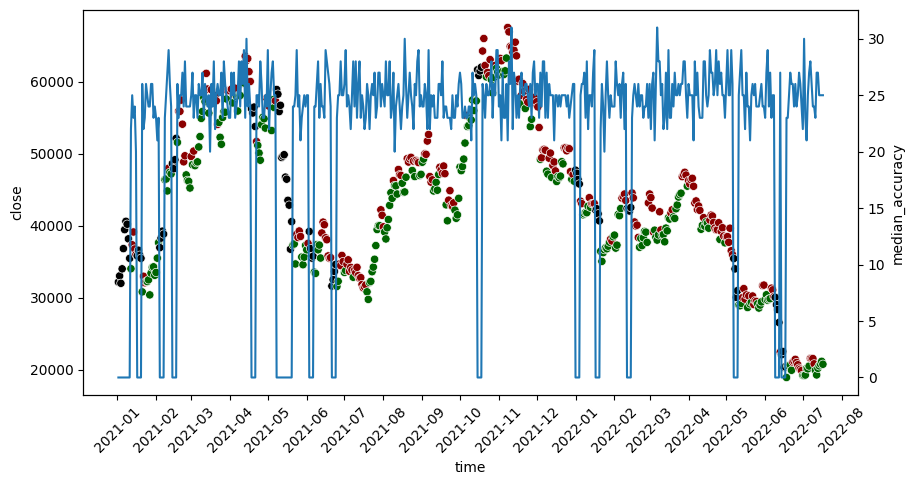

In [238]:
import seaborn as sns
import matplotlib.dates as md
fig,axes = plt.subplots(1,1,figsize=(10,5))
colors = ['black' if idx in banned_indices else 'darkgreen' if df['y_true'].iloc[idx] == 1 else 'darkred' for idx in range(len(df))]
df['time'] = pd.to_datetime(df['time'])
ax = sns.scatterplot(data=df, x="time", y="close", c=colors,ax=axes)
ax.xaxis.set_major_locator(md.MonthLocator(bymonth = list(range(0,13))))
# specify the format of the labels as 'year-month-day'
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m'))
# (optional) rotate by 90° the labels in order to improve their spacing
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45)
ax2 = ax.twinx()

df['median_accuray'].iloc[banned_indices].replace(0,pd.NA)

sns.lineplot(data=df, x="time", y="median_accuracy",ax=ax2)

In [240]:
df['median_accuracy'].iloc[banned_indices].replace(0,pd.NA)

IndexError: positional indexers are out-of-bounds

In [241]:
banned_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  15,  16,  17,
        18,  33,  34,  35,  36,  43,  44,  45,  46, 106, 107, 108, 109,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       152, 153, 154, 155, 170, 171, 172, 173, 286, 287, 288, 289, 364,
       365, 366, 367, 380, 381, 382, 383, 405, 406, 407, 408, 490, 491,
       492, 493, 523, 524, 525, 526, 528, 529, 530, 531, 562, 563, 564,
       565, 566])

In [242]:
df

,cnn,encoder_block,encoder_stack,lstm,mlp,y_true,close,median_accuracy,alpha,time
0,0,0,0,0,0,0,32203.64,0.0,0.000000,2021-01-02
1,0,0,0,0,0,0,33063.48,0.0,0.000000,2021-01-03
2,0,0,0,0,0,0,32030.55,0.0,0.000000,2021-01-04
3,0,0,0,0,0,0,34038.29,0.0,0.000000,2021-01-05
4,0,0,0,0,0,0,36849.86,0.0,0.000000,2021-01-06
...,...,...,...,...,...,...,...,...,...,...
557,21,22,28,33,27,1,20230.81,27.0,0.870968,2022-07-13
558,20,30,25,23,26,1,20577.38,25.0,0.806452,2022-07-14
559,21,25,22,27,25,1,20827.27,25.0,0.806452,2022-07-15
560,27,20,31,25,25,1,21199.01,25.0,0.806452,2022-07-16


In [243]:
df_raw = pd.DataFrame.from_dict(records).sort_index()
df_raw

,cnn,encoder_block,encoder_stack,lstm,mlp
0,22,19,29,16,23
1,19,25,24,29,28
2,19,28,32,23,21
3,27,27,20,24,23
4,24,18,20,26,18
...,...,...,...,...,...
482,21,22,28,33,27
483,20,30,25,23,26
484,21,25,22,27,25
485,27,20,31,25,25


<AxesSubplot:>

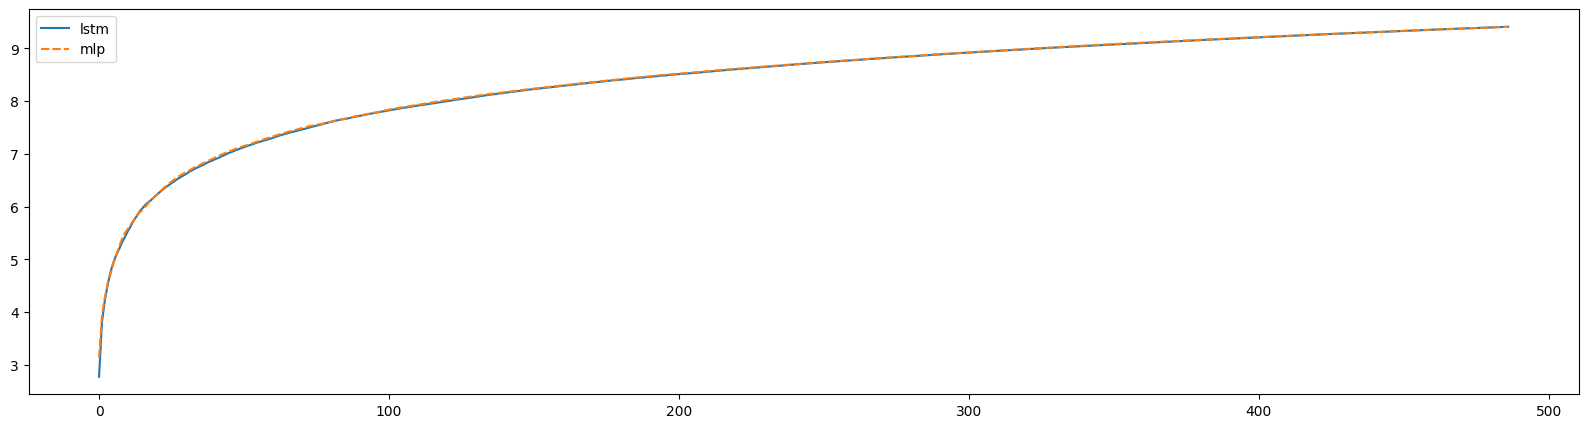

In [252]:
import seaborn as sns
fig,ax = plt.subplots(1,1,figsize=(20,5))
sns.lineplot(data = np.log(df_raw[['lstm','mlp']].cumsum()),ax=ax)